# Challenge 1


In [88]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import Sequence

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,  mean_squared_log_error


- use may to predict june, use both to predict july
- ignore earlier months for now

### Preprocessing

In [43]:
df_omie_labelled = pd.read_csv('data\\df_omie_labelled.csv')
filtered_categories = pd.read_csv('data\\filtered_categories.csv')
df_omie_blind = pd.read_csv('data\\df_omie_blind.csv')
unit_list = pd.read_csv('data\\unit_list.csv')

#### Conversions

In [44]:
unit_list["Tecnología"] = unit_list["Tecnología"].fillna("Unknown")

df_omie_labelled['fechaHora'] = pd.to_datetime(df_omie_labelled['fechaHora'])
df_omie_blind['fechaHora'] = pd.to_datetime(df_omie_blind['fechaHora'])

#### Normalize Data

In [45]:
columns_norm = ["PrecEuro", "Energia"]
may_data = df_omie_labelled[df_omie_labelled['fechaHora'].dt.month == 5]
june_data = df_omie_labelled[df_omie_labelled['fechaHora'].dt.month == 6]
may_june_data = pd.concat([may_data, june_data])

# MIN MAX SCALER (0-1)
minmax_scaler = MinMaxScaler()
df_omie_labelled[columns_norm] = minmax_scaler.fit_transform(df_omie_labelled[columns_norm])

may_data[['PrecEuro', 'Energia']] = minmax_scaler.fit_transform(may_data[['PrecEuro', 'Energia']])
june_data[['PrecEuro', 'Energia']] = minmax_scaler.transform(june_data[['PrecEuro', 'Energia']])
may_june_data[['PrecEuro', 'Energia']] = minmax_scaler.transform(may_june_data[['PrecEuro', 'Energia']])


C:\Users\annap\AppData\Local\Temp\ipykernel_13244\845283831.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  may_data[['PrecEuro', 'Energia']] = minmax_scaler.fit_transform(may_data[['PrecEuro', 'Energia']])
C:\Users\annap\AppData\Local\Temp\ipykernel_13244\845283831.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  june_data[['PrecEuro', 'Energia']] = minmax_scaler.transform(june_data[['PrecEuro', 'Energia']])


In [84]:
may_data.shape, june_data.shape, may_june_data.shape


((795336, 5), (24587, 5), (819923, 5))

In [85]:
may_data[columns_norm].describe()

,PrecEuro,Energia
count,795336.000000,795336.000000
mean,0.118543,0.004708
std,0.023366,0.018880
min,0.000000,0.000000
25%,0.116804,0.000000
50%,0.117906,0.000429
75%,0.117906,0.003577
max,1.000000,1.000000


In [86]:
june_data[columns_norm].describe()

,PrecEuro,Energia
count,24587.000000,24587.000000
mean,0.117701,0.006786
std,0.021665,0.027587
min,0.088503,0.000000
25%,0.115554,0.000000
50%,0.117906,0.001002
75%,0.117906,0.005974
max,0.411938,0.789039


In [87]:
may_june_data[columns_norm].describe()

,PrecEuro,Energia
count,819923.000000,819923.000000
mean,0.118518,0.004771
std,0.023317,0.019202
min,0.000000,0.000000
25%,0.116760,0.000000
50%,0.117906,0.000429
75%,0.117906,0.003649
max,1.000000,1.000000


#### Merging

In [46]:
df = pd.merge(df_omie_labelled, filtered_categories, on='Codigo', how='left')
df = pd.merge(df, unit_list, on='Codigo', how='left')
df = df.drop(columns=['Descripción', 'Agente', 'Porcentaje_Propiedad', 'Tipo_Unidad', 'Zona/Frontera'])
df.head()

,Codigo,Descripcion,fechaHora,PrecEuro,Energia,Categoria,Tecnología
0,ADXRE01,PREAL1,2024-02-29,0.142857,0.000000,Solar,RE Mercado Solar Fotovoltáica
1,ADXVD03,PV ALARCOS,2024-02-29,0.142857,0.000000,Solar,RE Mercado Solar Fotovoltáica
2,ADXVD04,EOLICA AUDAX,2024-02-29,0.142829,0.000535,Eolica,RE Mercado Eólica
3,AIRVD01,AIRVD01,2024-02-29,0.142857,0.000000,Solar,RE Mercado Solar Fotovoltáica
4,AIRVD02,AIRVD02,2024-02-29,0.142857,0.000000,Solar,RE Mercado Solar Fotovoltáica


In [47]:
df.describe()

,fechaHora,PrecEuro,Energia
count,2409526,2.409526e+06,2.409526e+06
mean,2024-04-15 23:10:13.309671168,1.434024e-01,2.746454e-03
min,2024-02-29 00:00:00,0.000000e+00,0.000000e+00
25%,2024-03-23 11:00:00,1.428286e-01,0.000000e+00
50%,2024-04-15 23:30:00,1.428571e-01,1.585100e-04
75%,2024-05-09 11:00:00,1.428571e-01,1.803051e-03
max,2024-06-01 22:00:00,1.000000e+00,1.000000e+00
std,NaN,2.395566e-02,1.429034e-02


### Sequence Generator

In [48]:
import psutil

available_memory = psutil.virtual_memory().available / (1024 ** 3)
total_memory = psutil.virtual_memory().total / (1024 ** 3)

print(f"Total Memory: {total_memory:.2f} GB")
print(f"Available Memory: {available_memory:.2f} GB")


Total Memory: 31.60 GB
Available Memory: 18.80 GB


In [49]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU Available: {gpus}")
else:
    print("No GPU found. Running on CPU.")


No GPU found. Running on CPU.


In [66]:
class EnergySequence(Sequence): 
    def __init__(self, data, target_col, sequence_length=24, batch_size=32):
        self.data = data
        self.target_col = target_col
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        # self.shuffle = shuffle
        # self.indices = np.arange(len(data)-sequence_length)

        # if self.shuffle:
        #     np.random.shuffle(self.indices)



    def __len__(self):
        return (len(self.data) - self.sequence_length)// self.batch_size
    

    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = start_idx + self.batch_size
        X, y = [],[]

        for i in range(start_idx, end_idx):
            if i + self.sequence_length < len(self.data):
                X.append(self.data.iloc[i : i + self.sequence_length])
                y.append(self.data.iloc[i + self.sequence_length, self.target_col])
                
        return np.array(X), np.array(y)
    


In [67]:
sequence_length = 24
batch_size = 64

train_generator = EnergySequence(may_data[['Energia','PrecEuro']], target_col=0, sequence_length=sequence_length, batch_size=batch_size)
test_generator = EnergySequence(june_data[['Energia','PrecEuro']], target_col=0, sequence_length=sequence_length, batch_size=batch_size)


### Model

In [68]:
model = Sequential([
    LSTM(30, activation='relu', return_sequences=True, input_shape=(sequence_length, 2)),
    Dropout(0.2), 
    LSTM(30, activation='relu'),
    Dropout(0.2), 
    Dense(20, activation='relu'), 
    Dense(1)                                 #output layer
])


model.compile(optimizer='adam', loss='mse')
model.summary()


c:\Users\annap\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 24, 30)         │         3,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 24, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 30)             │         7,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,921 (46.57 KB)

 Trainable params: 11,921 (46.57 KB)

 Non-trainable params: 0 (0.00 B)

#### Train

#### Train Model on Mays Data

In [70]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    verbose=1
)

Epoch 1/20


c:\Users\annap\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12426/12426 ━━━━━━━━━━━━━━━━━━━━ 463s 37ms/step - loss: 3.3967e-04 - val_loss: 7.3911e-04
Epoch 2/20
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 350s 28ms/step - loss: 3.3686e-04 - val_loss: 7.4153e-04
Epoch 3/20
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 280s 23ms/step - loss: 3.4310e-04 - val_loss: 7.4841e-04
Epoch 4/20
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 306s 25ms/step - loss: 3.4289e-04 - val_loss: 7.3632e-04
Epoch 5/20
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 325s 26ms/step - loss: 3.4116e-04 - val_loss: 7.3027e-04
Epoch 6/20
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 346s 28ms/step - loss: 3.2726e-04 - val_loss: 7.4302e-04
Epoch 7/20
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 359s 29ms/step - loss: 3.1162e-04 - val_loss: 7.3826e-04
Epoch 8/20
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 330s 27ms/step - loss: 3.2295e-04 - val_loss: 6.9748e-04
Epoch 9/20
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 291s 23ms/step - loss: 3.0327e-04 - val_loss: 7.5521e-04
Epoch 10/20
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 355s 29ms/step - loss: 2.9130e-04 - val_loss: 6.9033e-04


Results: 

Epoch 1/20
c:\Users\annap\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 463s 37ms/step - loss: 3.3967e-04 - val_loss: 7.3911e-04


Epoch 2/20
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 350s 28ms/step - loss: 3.3686e-04 - val_loss: 7.4153e-04


Epoch 3/20
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 280s 23ms/step - loss: 3.4310e-04 - val_loss: 7.4841e-04


Epoch 4/20
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 306s 25ms/step - loss: 3.4289e-04 - val_loss: 7.3632e-04


Epoch 5/20
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 325s 26ms/step - loss: 3.4116e-04 - val_loss: 7.3027e-04


Epoch 6/20
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 346s 28ms/step - loss: 3.2726e-04 - val_loss: 7.4302e-04


Epoch 7/20
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 359s 29ms/step - loss: 3.1162e-04 - val_loss: 7.3826e-04


Epoch 8/20
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 330s 27ms/step - loss: 3.2295e-04 - val_loss: 6.9748e-04


Epoch 9/20
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 291s 23ms/step - loss: 3.0327e-04 - val_loss: 7.5521e-04


Epoch 10/20
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 355s 29ms/step - loss: 2.9130e-04 - val_loss: 6.9033e-04


Epoch 11/20
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 349s 28ms/step - loss: 2.8907e-04 - val_loss: 7.0089e-04


Epoch 12/20
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 314s 25ms/step - loss: 2.8121e-04 - val_loss: 6.9224e-04


Epoch 13/20
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 321s 26ms/step - loss: 2.9023e-04 - val_loss: 6.8443e-04


Epoch 14/20
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 298s 24ms/step - loss: 2.8768e-04 - val_loss: 6.7393e-04


Epoch 15/20
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 302s 24ms/step - loss: 2.8024e-04 - val_loss: 6.5760e-04


Epoch 16/20
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 310s 25ms/step - loss: 2.7192e-04 - val_loss: 6.3135e-04


Epoch 17/20
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 347s 28ms/step - loss: 2.7577e-04 - val_loss: 4.9863e-04


Epoch 18/20
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 348s 28ms/step - loss: 2.8044e-04 - val_loss: 6.7875e-04


Epoch 19/20
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 295s 24ms/step - loss: 2.6612e-04 - val_loss: 6.5265e-04


Epoch 20/20
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 280s 23ms/step - loss: 2.7465e-04 - val_loss: 6.6127e-04

#### Evaluate

In [71]:
loss = model.evaluate(test_generator)
print(f"Test Loss: {loss}")


383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 6.6710e-04
Test Loss: 0.0006612712168134749


Results: 

383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 6.6710e-04


Test Loss: 0.0006612712168134749

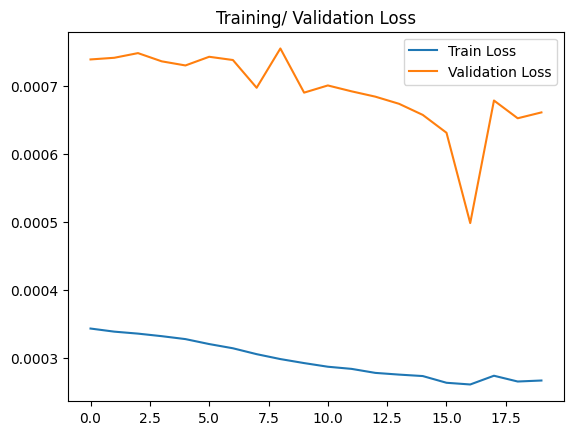

In [72]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training/ Validation Loss')
plt.show()

Results: 

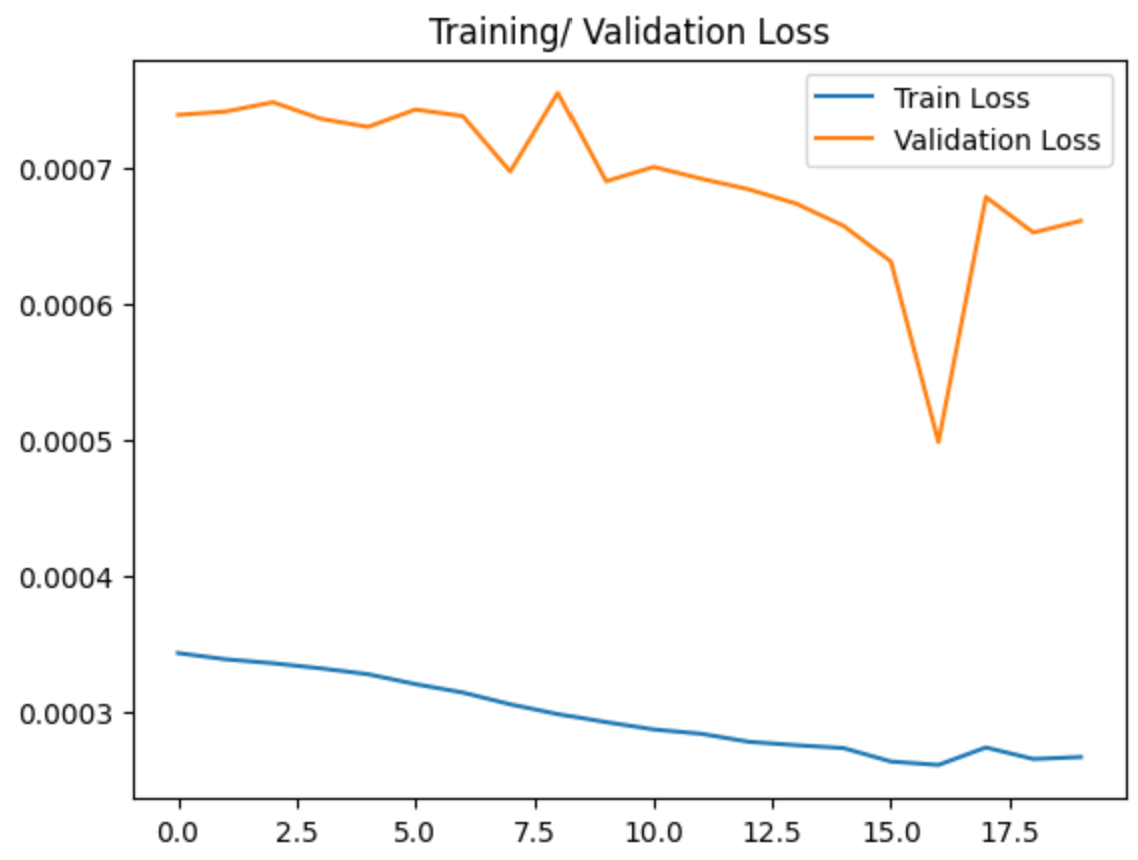

### Predictions

#### Predit Junes Data

In [74]:
june_predictions = model.predict(test_generator)

june_dates = june_data['fechaHora'].iloc[sequence_length:sequence_length+len(june_predictions)].values
june_pred_df = pd.DataFrame({'fechaHora': june_dates, 'Predicted_Energia': june_predictions.flatten(), 'Actual_Energia': june_data['Energia'].iloc[sequence_length:sequence_length+len(june_predictions)].values})

383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


Results: 

383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step

In [91]:
mae = mean_absolute_error(june_pred_df['Actual_Energia'], june_pred_df['Predicted_Energia'])
rmse = np.sqrt(mean_squared_error(june_pred_df['Actual_Energia'], june_pred_df['Predicted_Energia']))
r2 = r2_score(june_pred_df['Actual_Energia'], june_pred_df['Predicted_Energia'])
# msle = mean_squared_log_error(june_pred_df['Actual_Energia'], june_pred_df['Predicted_Energia'])


print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")
# print(f"MSLE: {msle}")

MAE: 0.007146780506575386
RMSE: 0.025715197488005093
R-squared: 0.13266499153681466


Results:

MAE: 0.007146780506575386

RMSE: 0.025715197488005093

R-squared: 0.13266499153681466

In [ ]:
def adjusted_r2(X, y, model):
    n = len(y)  
    p = X.shape[1]  
    r2 = model.score(X, y) 
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return adjusted_r2


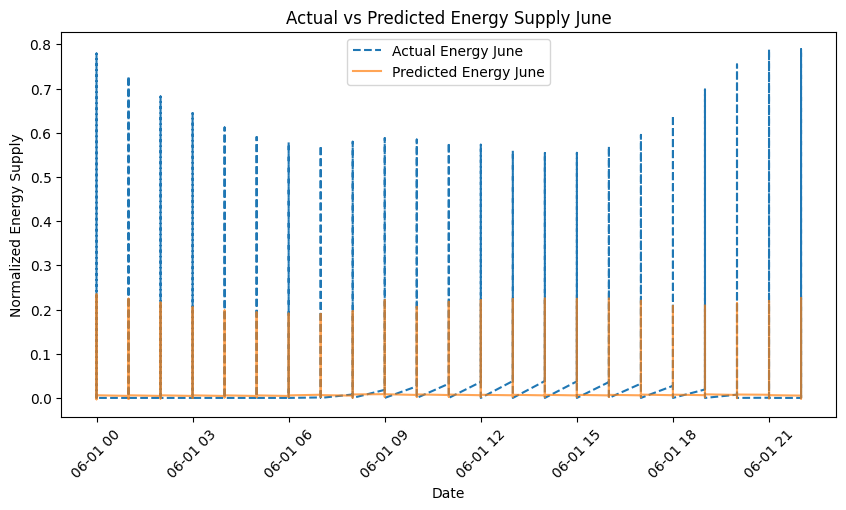

In [75]:
plt.figure(figsize=(10,5))
plt.plot(june_pred_df['fechaHora'], june_pred_df['Actual_Energia'], label="Actual Energy June", linestyle="dashed")
plt.plot(june_pred_df['fechaHora'], june_pred_df['Predicted_Energia'], label="Predicted Energy June", alpha=0.7)
plt.legend()
plt.title("Actual vs Predicted Energy Supply June")
plt.xlabel("Date")
plt.ylabel("Normalized Energy Supply")
plt.xticks(rotation=45)
plt.show()

Results: 

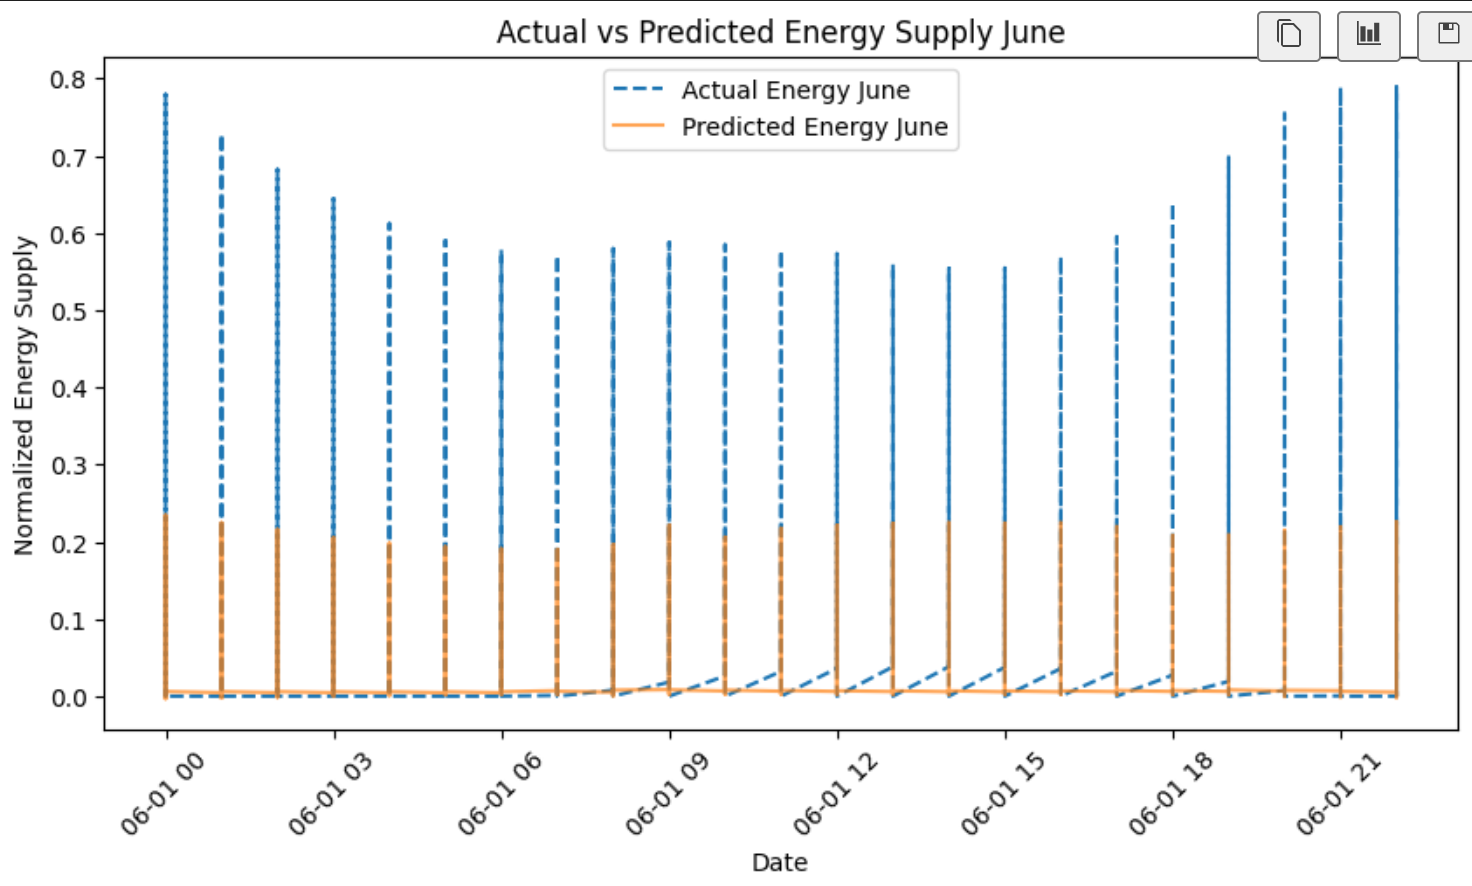

Residuals - June

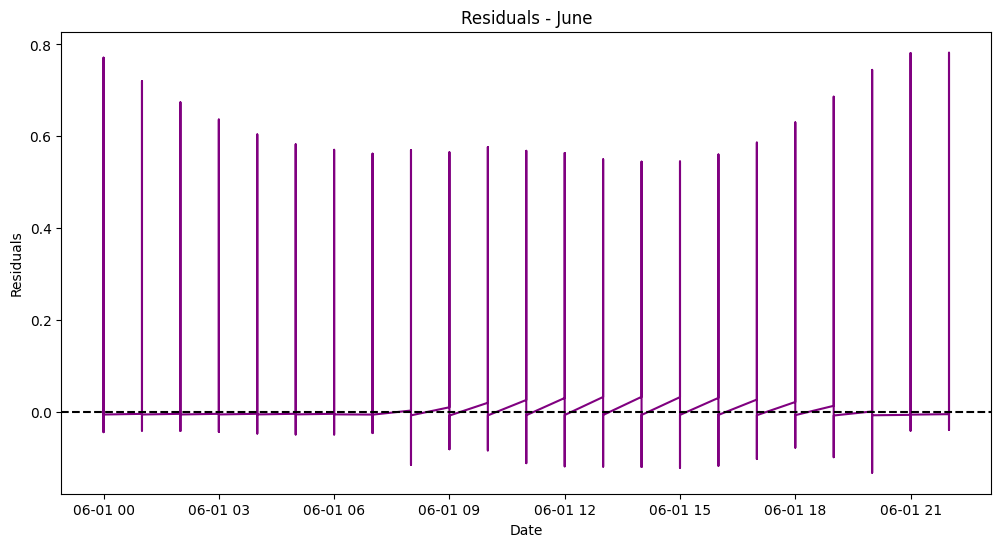

In [79]:
residuals = june_pred_df['Actual_Energia'] - june_pred_df['Predicted_Energia']
plt.figure(figsize=(12,6))
plt.plot(june_pred_df['fechaHora'], residuals, label="Residuals", color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.title("Residuals - June")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.show()

Results: 

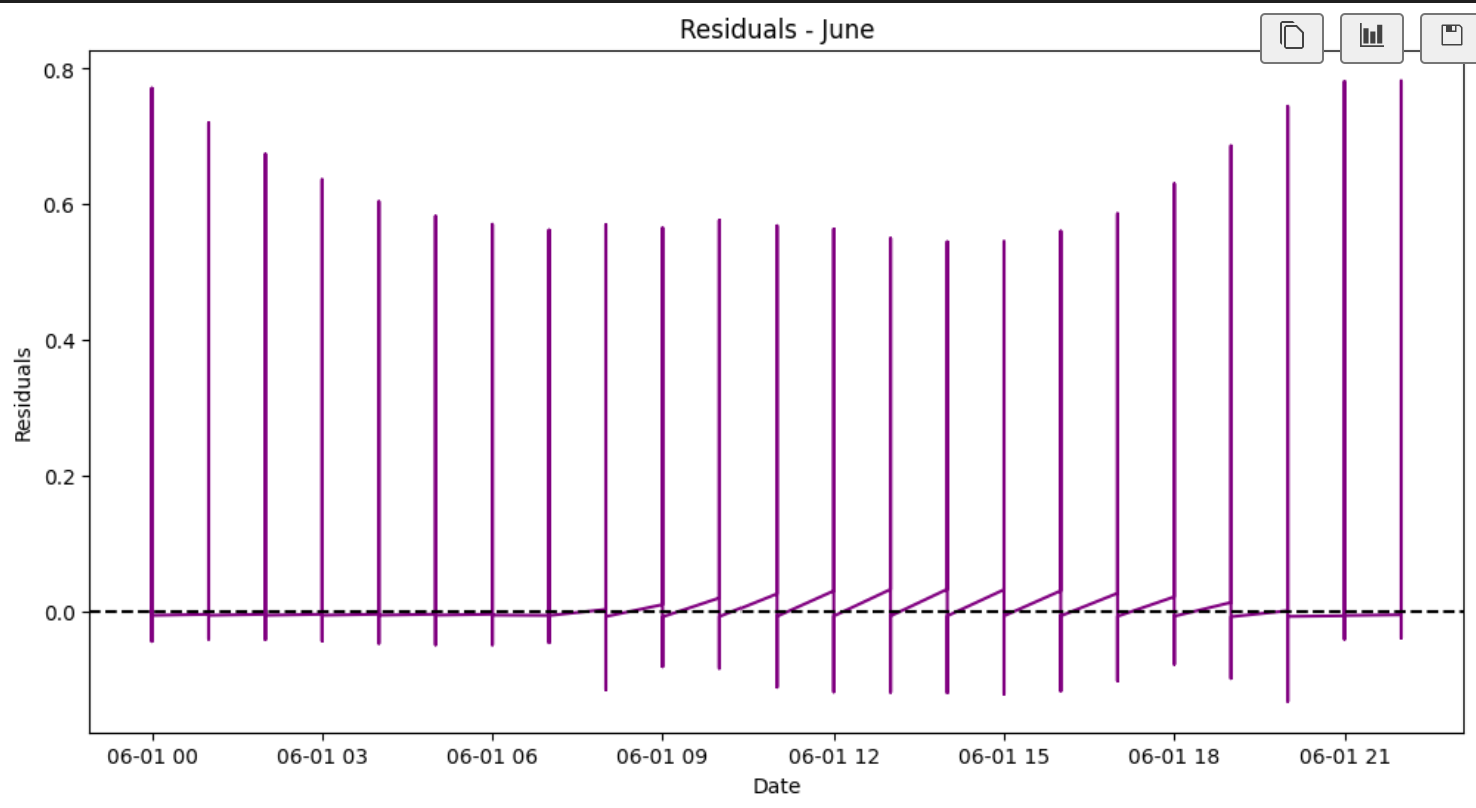

#### Predict July

In [76]:
future_generator = EnergySequence(may_june_data[['Energia', 'PrecEuro']], target_col=0, sequence_length=sequence_length, batch_size=batch_size)
july_predictions = model.predict(future_generator)

july_dates = pd.date_range(start="2024-07-01", periods=len(july_predictions), freq="H")
july_df = pd.DataFrame({'fechaHora': july_dates, 'Predicted_Energia': july_predictions.flatten()})


    5/12810 ━━━━━━━━━━━━━━━━━━━━ 2:50 13ms/step 

c:\Users\annap\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12810/12810 ━━━━━━━━━━━━━━━━━━━━ 144s 11ms/step


Results: 

5/12810 ━━━━━━━━━━━━━━━━━━━━ 2:50 13ms/step 
  
12810/12810 ━━━━━━━━━━━━━━━━━━━━ 144s 11ms/step

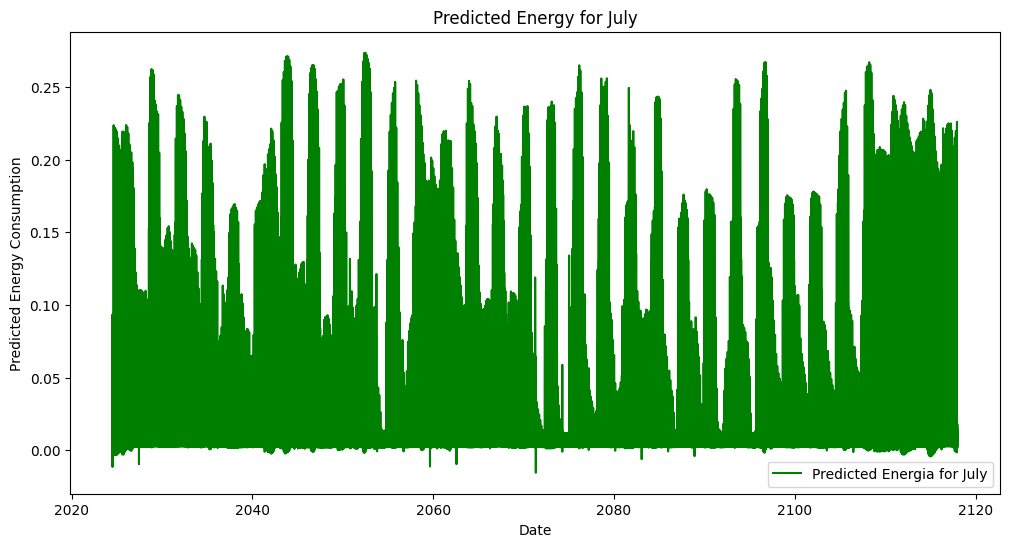

In [83]:
plt.figure(figsize=(12,6))
plt.plot(july_df['fechaHora'], july_df['Predicted_Energia'], label="Predicted Energia for July", color='green')
plt.legend()
plt.title("Predicted Energy for July")
plt.xlabel("Date")
plt.ylabel("Predicted Energy Consumption")
plt.show()


Results: 

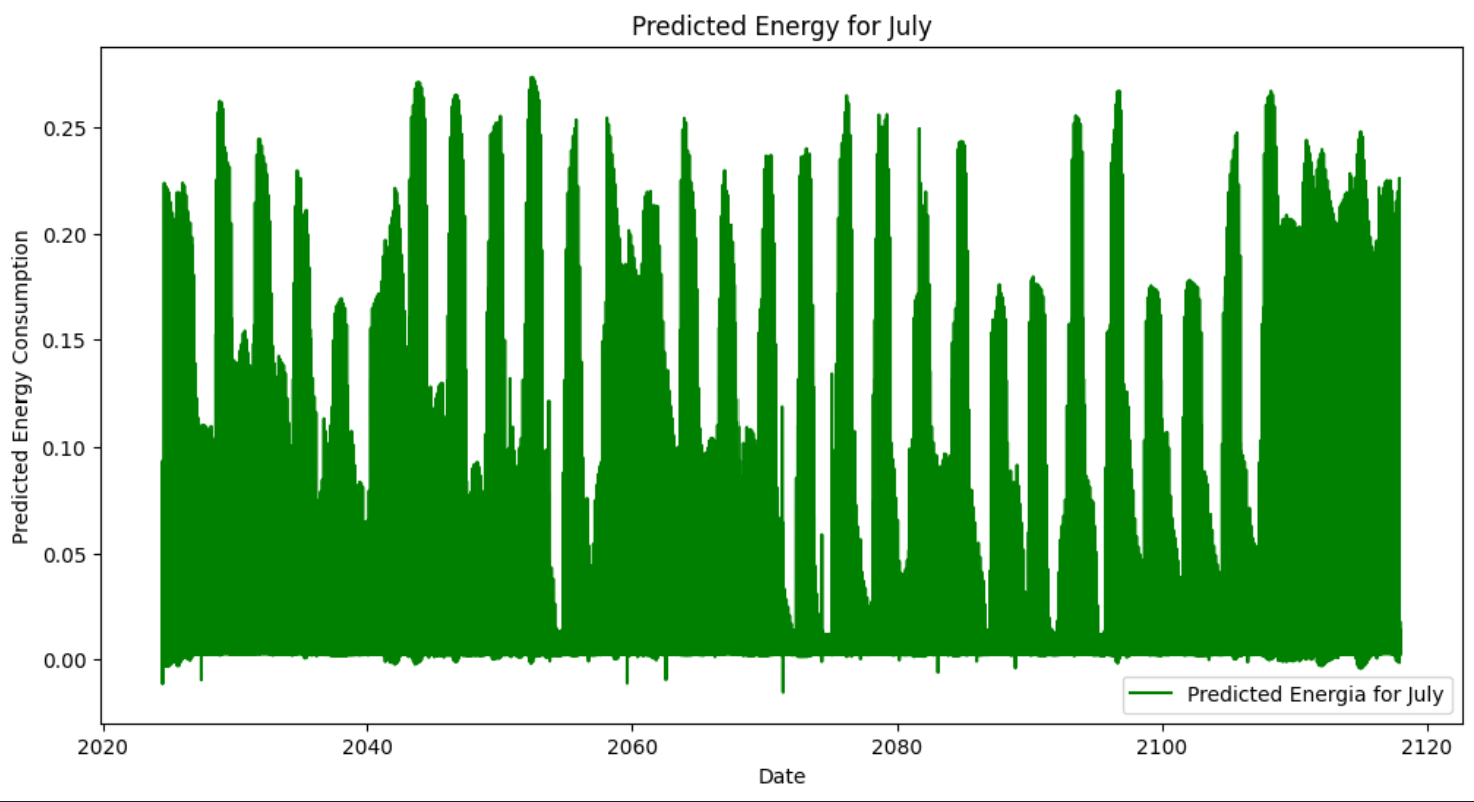

In [77]:
# def forecast_future(model, data, sequence_length, steps=24*30):   # 30 days, hourly - July
#     predictions = []
#     current_sequence = data[-sequence_length:].values  #latest data
    
#     for _ in range(steps):
#         input_seq = current_sequence.reshape((1, sequence_length, 2))  #reshape for LSTM
#         pred = model.predict(input_seq)[0, 0]  #forecasts next hour
#         predictions.append(pred)
#         current_sequence = np.append(current_sequence[1:], [[pred, 0]], axis=0) #remove oldest, appended newest predict
    
#     return np.array(predictions)



# future_preds = forecast_future(model, df[['Energia', 'PrecEuro']], sequence_length, steps=24*29)

In [78]:
# plt.figure(figsize=(10, 5))
# plt.plot(future_preds, label= "Forecasted Energy Supply")
# plt.title("Energy Supply Forecast (June 1-June 29th, 2024)")
# plt.legend()
# plt.show()